<a href="https://colab.research.google.com/github/crodier1/machine_learning_deep_learning/blob/main/CNN_Airline_Tweet_Sentiment_Anaylsis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from sklearn.metrics import roc_auc_score
from tensorflow.keras.regularizers import l2
!pip install opendatasets
import opendatasets as od
from keras.utils import to_categorical

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/exercises/AirlineSentimentTweets.csv

File ‘AirlineSentimentTweets.csv’ already there; not retrieving.



In [3]:
df = pd.read_csv('AirlineSentimentTweets.csv')

In [4]:
df['negativereason'] = df['negativereason'].fillna('none')

df['negativereason'] = df['negativereason'].map({'Bad Flight': 1,
 "Can't Tell": 1,
 'Cancelled Flight': 2,
 'Customer Service Issue': 3,
 'Damaged Luggage': 4,
 'Flight Attendant Complaints': 5,
 'Flight Booking Problems': 6,
 'Late Flight': 7,
 'Lost Luggage': 8,
 'longlines': 9,
 'none': 0})


In [5]:
K = len(set(df['airline_sentiment']))
K

3

In [6]:
df['airline_sentiment'] = df['airline_sentiment'].map({'negative':0, 'neutral':1, 'positive':2})

In [7]:
df2 = df[['text', 'airline_sentiment']]


In [8]:
if not os.path.exists("/content/glove6b"):
  od.download("https://nlp.stanford.edu/data/glove.6B.zip")
  !unzip glove.6B.zip -d /content/glove6b

In [9]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20_000
EMBEDING_DIM = 100
VALIDATION_SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 128

In [10]:
print('Loading word vectors...')
word2vec = {}

with open(os.path.join('/content/glove6b/glove.6B.%sd.txt' % EMBEDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [11]:
sentences = df['text'].fillna('none').values
targets = df['airline_sentiment'].values
targets = to_categorical(targets)

In [12]:
print('max sequence length:', max(len(s) for s in sentences))
print('min sequence length:', min(len(s) for s in sentences))
s = sorted(len(s) for s in sentences)
print('median sequence length:', s[len(s) // 2])

max sequence length: 186
min sequence length: 12
median sequence length: 114


In [13]:
tolkenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tolkenizer.fit_on_texts(sentences)
sequences = tolkenizer.texts_to_sequences(sentences)

In [14]:
word2idx = tolkenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 15768 unique tokens.


In [15]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (14640, 100)


In [16]:
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [17]:
embedding_layer = Embedding(
    num_words,
    EMBEDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [18]:
print('building model...')
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(64, 5, activation='relu', kernel_regularizer=l2(0.01))(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 5, activation='relu', kernel_regularizer=l2(0.01))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.6)(x)
output = Dense(K, activation='softmax')(x)


building model...


In [19]:
model = Model(input_, output)
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [20]:
print('training model...')
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)

training model...
Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.5699 - loss: 2.5882 - val_accuracy: 0.7493 - val_loss: 1.3667
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.6836 - loss: 1.3068 - val_accuracy: 0.7900 - val_loss: 0.8615
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.7372 - loss: 0.9477 - val_accuracy: 0.7947 - val_loss: 0.7619
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/step - accuracy: 0.7562 - loss: 0.8151 - val_accuracy: 0.8050 - val_loss: 0.6732
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.7765 - loss: 0.7459 - val_accuracy: 0.8163 - val_loss: 0.6475
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.7777 - loss: 0.7338 - val_accuracy: 0.8132 - val_loss: 0.6427
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.7830 - loss: 0.7082 - val_accuracy: 0.8142 - val_loss: 0.6332
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - accuracy: 0.7894 - loss: 0.68

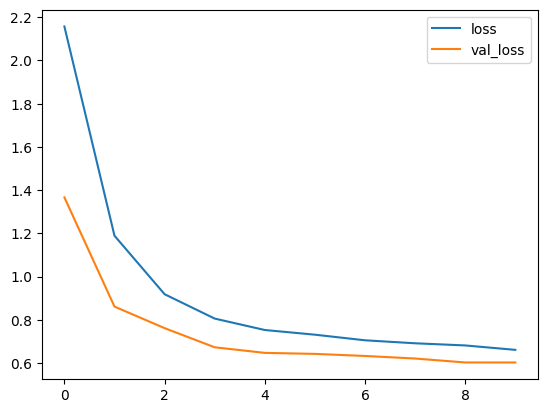

In [21]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

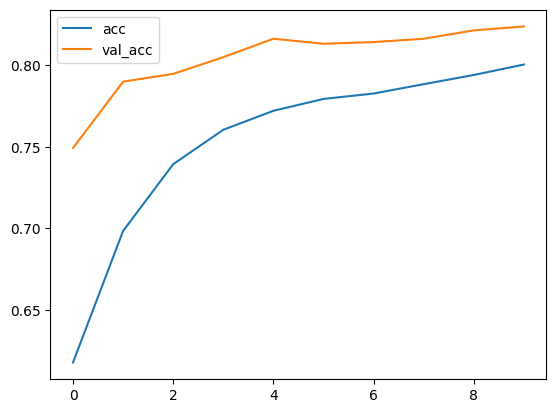

In [22]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()